# Function: Monte Carlo Stock Price generation

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime, timedelta

# Monte Carlo Stock Price Simulation for configurable intervals
def generate_stock_price_data(interval=5, hours=23):
    """
    Generate stock price data for specified hours using Monte Carlo method
    
    Parameters:
    -----------
    interval : int, default=5
        Time interval in seconds between each price point
    hours : int, default=23
        Number of hours to simulate (6 PM to 5 PM next day = 23 hours)
    """
    # Parameters
    initial_price = 100.0  # Starting stock price
    drift = 0.0001  # Daily drift (scaled for interval)
    volatility = 0.02  # Daily volatility
    
    # Calculate time step and number of steps based on interval
    time_step = interval / (24 * 60 * 60)  # Convert seconds to fraction of day
    num_steps = int(hours * 60 * 60 / interval)  # Total intervals in specified hours
    
    # Generate time series starting at 6 PM (18:00)
    start_time = datetime.now().replace(hour=18, minute=0, second=0, microsecond=0)
    timestamps = [start_time + timedelta(seconds=i*interval) for i in range(num_steps)]
    
    # Monte Carlo simulation using Geometric Brownian Motion
    prices = [initial_price]
    
    for i in range(1, num_steps):
        # Random shock (normal distribution)
        random_shock = np.random.normal(0, 1)
        
        # Calculate price change using GBM formula
        price_change = drift * time_step + volatility * np.sqrt(time_step) * random_shock
        
        # Calculate new price
        new_price = prices[-1] * np.exp(price_change)
        prices.append(new_price)
    
    # Create DataFrame
    stock_data = pd.DataFrame({
        'timestamp': timestamps,
        'price': prices
    })
    
    return stock_data


# Function: Get Data from OANDA

In [3]:
# OANDA Live FXTrade API Connection
import requests
import pandas as pd
from datetime import datetime, timedelta
import json

def get_oanda_data(api_key, account_id, instrument='USD_CAD', granularity='S5', hours=10):
    """
    Connect to OANDA live fxtrade environment and fetch real market data
    
    Parameters:
    -----------
    api_key : str
        Your OANDA API key from live account
    account_id : str
        Your OANDA live account ID
    instrument : str, default='USD_CAD'
        Currency pair to fetch
    granularity : str, default='S5'
        Time granularity (S5 = 5 seconds)
    hours : int, default=10
        Number of hours of historical data to fetch
    
    Returns:
    --------
    pandas.DataFrame
        DataFrame with real market data
    """
    
    # LIVE OANDA API URL (NOT practice!)
    BASE_URL = "https://api-fxtrade.oanda.com"
    
    print("🔴 CONNECTING TO OANDA LIVE FXTRADE ENVIRONMENT")
    print("=" * 55)
    print("⚠️  WARNING: This will connect to LIVE market data")
    print(f"📊 Requesting: {instrument} | {granularity} | Last {hours} hours")
    print("=" * 55)
    
    # Validate inputs
    if not api_key or api_key == "your_live_api_key_here":
        print("❌ ERROR: Live API key is required!")
        print("\n🔧 TO GET YOUR LIVE OANDA CREDENTIALS:")
        print("1. Log into your OANDA account at: https://www.oanda.com/")
        print("2. Go to 'Manage API Access' in account settings")
        print("3. Generate a Personal Access Token")
        print("4. Copy your Account ID from account overview")
        print("\n💡 USAGE:")
        print("live_data = connect_oanda_live(")
        print("    api_key='your_actual_api_key',")
        print("    account_id='your_actual_account_id'")
        print(")")
        return None
    
    if not account_id or account_id == "your_live_account_id_here":
        print("❌ ERROR: Live Account ID is required!")
        return None
    
    # Headers for API request
    headers = {
        'Authorization': f'Bearer {api_key}',
        'Content-Type': 'application/json',
        'Accept': 'application/json'
    }
    
    # Calculate count based on granularity and hours
    if granularity == 'S5':
        count = min(hours * 60 * 12, 5000)  # 12 five-second intervals per minute, max 5000
    elif granularity == 'S10':
        count = min(hours * 60 * 6, 5000)   # 6 ten-second intervals per minute
    elif granularity == 'M1':
        count = min(hours * 60, 5000)       # 60 one-minute intervals per hour
    elif granularity == 'M5':
        count = min(hours * 12, 5000)       # 12 five-minute intervals per hour
    else:
        count = min(7200, 5000)  # Default fallback
    
    # API endpoint for historical candles
    url = f"{BASE_URL}/v3/instruments/{instrument}/candles"
    
    # Parameters for the request
    params = {
        'count': count,
        'granularity': granularity#,
        # 'price': 'MBA',  # Mid, Bid, Ask prices
        # 'includeFirst': 'true'
    }
    
    try:
        print(f"🌐 Making API request to OANDA live servers...")
        print(f"   URL: {url}")
        print(f"   Params: {params}")
        
        # Make the API request
        response = requests.get(url, headers=headers, params=params, timeout=30)
        
        # Check for HTTP errors
        if response.status_code == 401:
            print("❌ AUTHENTICATION ERROR (401)")
            print("   • Check your API key is correct")
            print("   • Ensure your API key has proper permissions")
            print("   • Verify you're using the live account API key")
            return None
        elif response.status_code == 403:
            print("❌ FORBIDDEN ERROR (403)")
            print("   • Your account may not have API access enabled")
            print("   • Check if your account is verified and funded")
            return None
        elif response.status_code == 404:
            print("❌ NOT FOUND ERROR (404)")
            print(f"   • Check instrument name: {instrument}")
            print(f"   • Check granularity: {granularity}")
            return None
        elif response.status_code != 200:
            print(f"❌ HTTP ERROR {response.status_code}")
            print(f"   Response: {response.text}")
            return None
        
        # Parse JSON response
        data = response.json()
        
        if 'candles' not in data:
            print("❌ ERROR: No candles data in response")
            print(f"Response: {data}")
            return None
        
        candles = data['candles']
        print(f"✅ Successfully received {len(candles)} candles from OANDA live")
        
        # Convert to DataFrame
        market_data = []
        for candle in candles:
            timestamp = pd.to_datetime(candle['time'])
            
            # Extract OHLC data
            mid = candle.get('mid', {})
            bid = candle.get('bid', {})
            ask = candle.get('ask', {})
            
            if not mid:
                continue  # Skip if no mid prices
            
            # Get prices
            open_price = float(mid['o'])
            high_price = float(mid['h'])
            low_price = float(mid['l'])
            close_price = float(mid['c'])
            
            bid_price = float(bid.get('c', close_price - 0.0001))
            ask_price = float(ask.get('c', close_price + 0.0001))
            
            # Calculate spread in pips (for USD/CAD, 1 pip = 0.0001)
            spread_pips = (ask_price - bid_price) * 10000
            
            market_data.append({
                'timestamp': timestamp,
                'open': open_price,
                'high': high_price,
                'low': low_price,
                'close': close_price,
                'mid': close_price,
                'bid': bid_price,
                'ask': ask_price,
                'volume': candle.get('volume', 0),
                'spread_pips': round(spread_pips, 1),
                'complete': candle.get('complete', True)
            })
        
        if not market_data:
            print("❌ ERROR: No valid market data received")
            return None
        
        # Create DataFrame
        df = pd.DataFrame(market_data)
        
        # Add price column for compatibility with EMA functions
        df['price'] = df['close']
        
        # Sort by timestamp to ensure chronological order
        df = df.sort_values('timestamp').reset_index(drop=True)
        
        print(f"\n📊 LIVE MARKET DATA SUMMARY:")
        print(f"   • Instrument: {instrument}")
        print(f"   • Granularity: {granularity}")
        print(f"   • Total candles: {len(df):,}")
        print(f"   • Time range: {df['timestamp'].min()} to {df['timestamp'].max()}")
        print(f"   • Price range: {df['close'].min():.5f} - {df['close'].max():.5f}")
        print(f"   • Current price: {df['close'].iloc[-1]:.5f}")
        print(f"   • Average spread: {df['spread_pips'].mean():.1f} pips")
        
        # Show latest data
        print(f"\n📈 LATEST 3 CANDLES:")
        latest_cols = ['timestamp', 'open', 'high', 'low', 'close', 'bid', 'ask', 'spread_pips']
        print(df[latest_cols].tail(3).to_string(index=False, float_format='%.5f'))
        

        # return the dataframe with timestamp and  price columns
        return df[['timestamp', 'price']]
        
    except requests.exceptions.Timeout:
        print("❌ TIMEOUT ERROR: Request took too long")
        print("   • Try again or reduce the number of hours")
        return None
    except requests.exceptions.ConnectionError:
        print("❌ CONNECTION ERROR: Cannot reach OANDA servers")
        print("   • Check your internet connection")
        print("   • OANDA servers may be temporarily unavailable")
        return None
    except requests.exceptions.RequestException as e:
        print(f"❌ REQUEST ERROR: {e}")
        return None
    except json.JSONDecodeError:
        print("❌ JSON ERROR: Invalid response from OANDA")
        print(f"   Response: {response.text[:200]}...")
        return None
    except Exception as e:
        print(f"❌ UNEXPECTED ERROR: {e}")
        return None

# # Example usage (you need to provide your actual credentials)
# print("🔧 OANDA LIVE TRADING API SETUP")
# print("=" * 40)
# print("To fetch live USD/CAD data, use:")
# print()
# print("live_usdcad = connect_oanda_live(")
# print("    api_key='your_actual_live_api_key',")
# print("    account_id='your_actual_live_account_id',")
# print("    instrument='USD_CAD',")
# print("    granularity='S5',")
# print("    hours=10")
# print(")")
# print()
# print("⚠️  Replace with your actual OANDA live credentials!")
# print("📖 Get credentials from: https://www.oanda.com/account/tpa/personal_token")






# Function: Transform 5 second data to variable interval data

In [4]:
def create_variable_interval_data(base_df, min_interval, max_interval):
    """
    Create a new DataFrame with variable time intervals by randomly removing rows
    
    Parameters:
    -----------
    base_df : pandas.DataFrame
        Base DataFrame with 'timestamp' and 'price' columns
    min_interval : int, default=1
        Minimum time interval in seconds
    max_interval : int, default=60
        Maximum time interval in seconds
    
    Returns:
    --------
    pandas.DataFrame
        New DataFrame with variable time intervals
    """
    
    # Start with first row
    variable_data = [base_df.iloc[0]]
    current_index = 0
    
    while current_index < len(base_df) - 1:
        # Generate random interval between min and max seconds
        random_interval = np.random.randint(min_interval, max_interval + 1)
        
        # Move forward by this interval (in seconds)
        next_index = current_index + random_interval
        
        # Make sure we don't exceed the DataFrame length
        if next_index < len(base_df):
            variable_data.append(base_df.iloc[next_index])
            current_index = next_index
        else:
            # Add the last row if we haven't reached it
            if current_index != len(base_df) - 1:
                variable_data.append(base_df.iloc[-1])
            break
    
    # Create new DataFrame
    variable_df = pd.DataFrame(variable_data).reset_index(drop=True)
    
    return variable_df


# Function: Calculate time based EMAs (including TEMA)

In [5]:
import numpy as np
import pandas as pd
from datetime import timedelta

def calculate_time_based_ema(stock_df, type=1, period_minutes=15):
    """
    Calculate Exponential Moving Average based on actual time period (minutes) using timestamps.
    
    Parameters:
    -----------
    stock_df : pandas.DataFrame
        DataFrame containing 'timestamp' and 'price' columns
    period_minutes : int, default=15
        The time period in minutes for the EMA calculation
    
    Returns:
    --------
    pandas.Series
        Series containing the EMA values aligned with the input DataFrame index
    
    Notes:
    ------
    - This function is truly time-based and uses actual timestamps, not row counts
    - The smoothing factor (alpha) is calculated based on the actual time period
    - Works with any data frequency (1-second, 5-second, 1-minute, etc.)
    - EMA formula: EMA_today = (Price_today * α) + (EMA_yesterday * (1 - α))
    - Where α = 2 / (N + 1), and N is calculated from the actual time period
    """
    
    # Validate input DataFrame
    if not isinstance(stock_df, pd.DataFrame):
        raise ValueError("stock_df must be a pandas DataFrame")
    
    if 'timestamp' not in stock_df.columns or 'price' not in stock_df.columns:
        raise ValueError("DataFrame must contain 'timestamp' and 'price' columns")
    
    if len(stock_df) == 0:
        return pd.Series(dtype=float)
    
    if len(stock_df) < 2:
        # If only one data point, return the price itself
        return pd.Series([stock_df['price'].iloc[0]], index=stock_df.index)
    
    # Calculate the actual time interval between data points (in seconds)
    time_diffs = stock_df['timestamp'].diff().dropna()
    avg_interval_seconds = time_diffs.dt.total_seconds().mean()
    
    # Calculate the equivalent number of periods for the specified time window
    period_seconds = period_minutes * 60
    equivalent_periods = period_seconds / avg_interval_seconds
    
    # Calculate smoothing factor (alpha) based on equivalent periods
    # Using standard EMA formula: α = 2 / (N + 1)
    alpha = 2.0 / (equivalent_periods + 1)
    
    # Initialize EMA series
    ema_values = []
    dema_values = []
    tema_values = []
    purple_values = []
    
    # First EMA value is the first price
    first_price = stock_df['price'].iloc[0]
    ema_values.append(first_price)
    dema_values.append(first_price)
    tema_values.append(first_price)
    purple_values.append(first_price)  # Initial purple value
    
    # Calculate EMA for subsequent values using time-based smoothing
    for i in range(1, len(stock_df)):
        current_price = stock_df['price'].iloc[i]
        previous_ema = ema_values[-1]
        previous_dema = dema_values[-1]
        previous_tema = tema_values[-1]

        # Calculate time elapsed since previous data point
        time_elapsed = (stock_df['timestamp'].iloc[i] - stock_df['timestamp'].iloc[i-1]).total_seconds()
        
        # Adjust alpha based on actual time elapsed vs expected interval
        # This ensures consistency regardless of irregular timestamps
        time_weight = time_elapsed / avg_interval_seconds
        adjusted_alpha = 1 - (1 - alpha) ** time_weight
        
        # EMA formula with time-adjusted smoothing
        current_ema = adjusted_alpha * current_price + (1 - adjusted_alpha) * previous_ema
        current_dema = adjusted_alpha * current_ema + (1 - adjusted_alpha) * previous_dema
        current_tema = adjusted_alpha * current_dema + (1 - adjusted_alpha) * previous_tema
        
        ema_values.append(current_ema)
        dema_values.append(current_dema)
        tema_values.append(current_tema)
        purple_values.append(3 * (current_ema - current_dema) + current_tema)
    
    # Return as pandas Series with the same index as input DataFrame
    if type == 1:
        return pd.Series(ema_values, index=stock_df.index, name=f'EMA_{period_minutes}min')
    elif type == 2:
        return pd.Series(dema_values, index=stock_df.index, name=f'DEMA_{period_minutes}min')
    elif type == 3:
        return pd.Series(purple_values, index=stock_df.index, name=f'TEMA_{period_minutes}min')
    else:
        raise ValueError("Invalid type specified. Use 1 for EMA, 2 for DEMA, or 3 for TEMA.")


# Execution: Generate data, either with Monte Carlo or OANDA

Generating stock price data using Monte Carlo method...


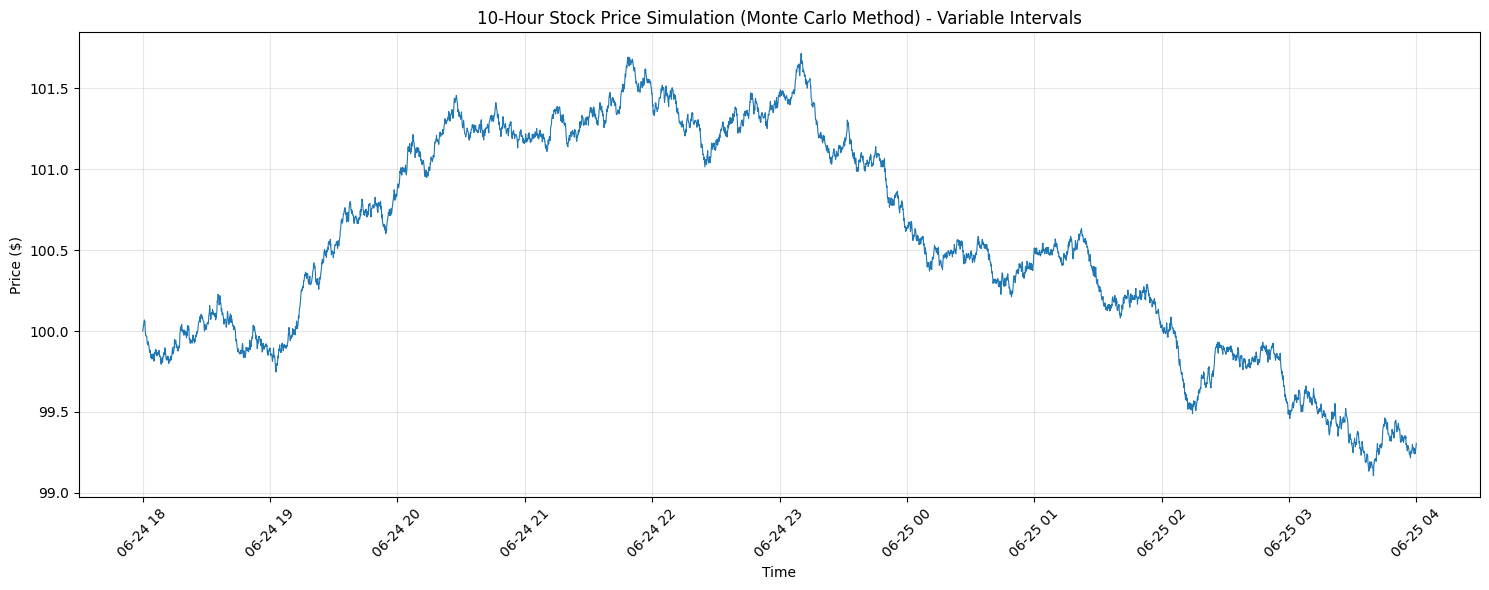

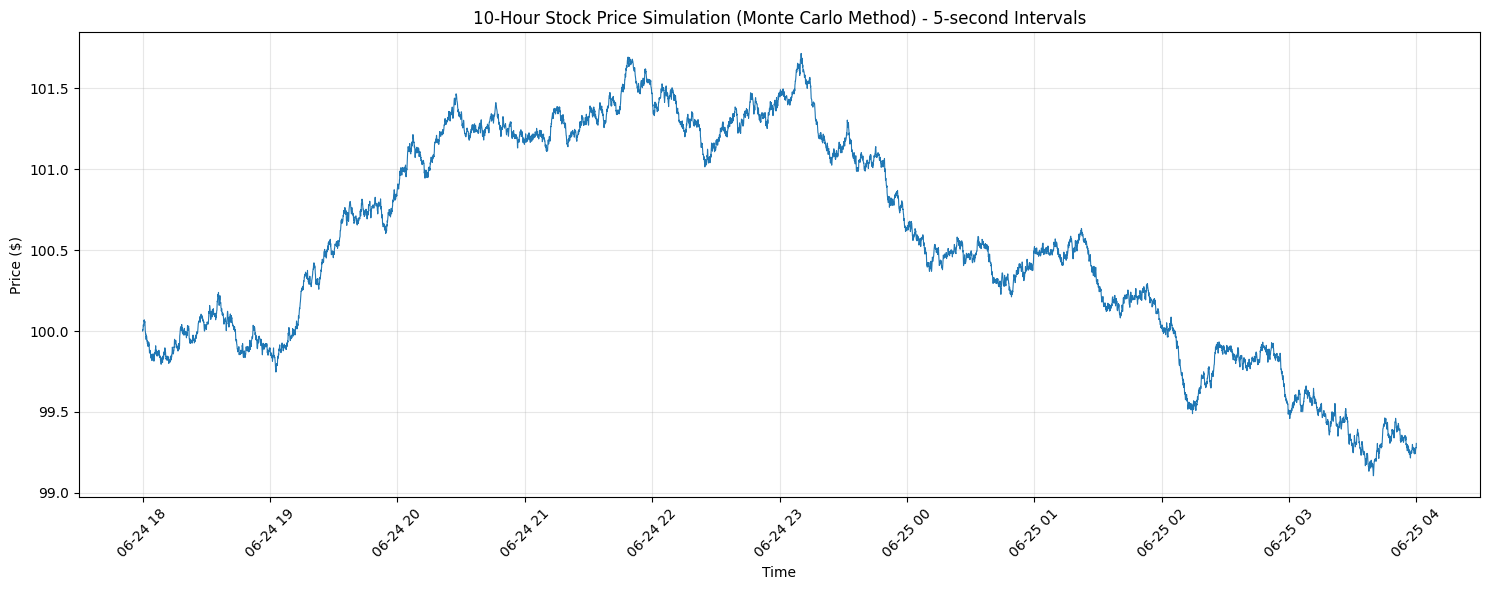

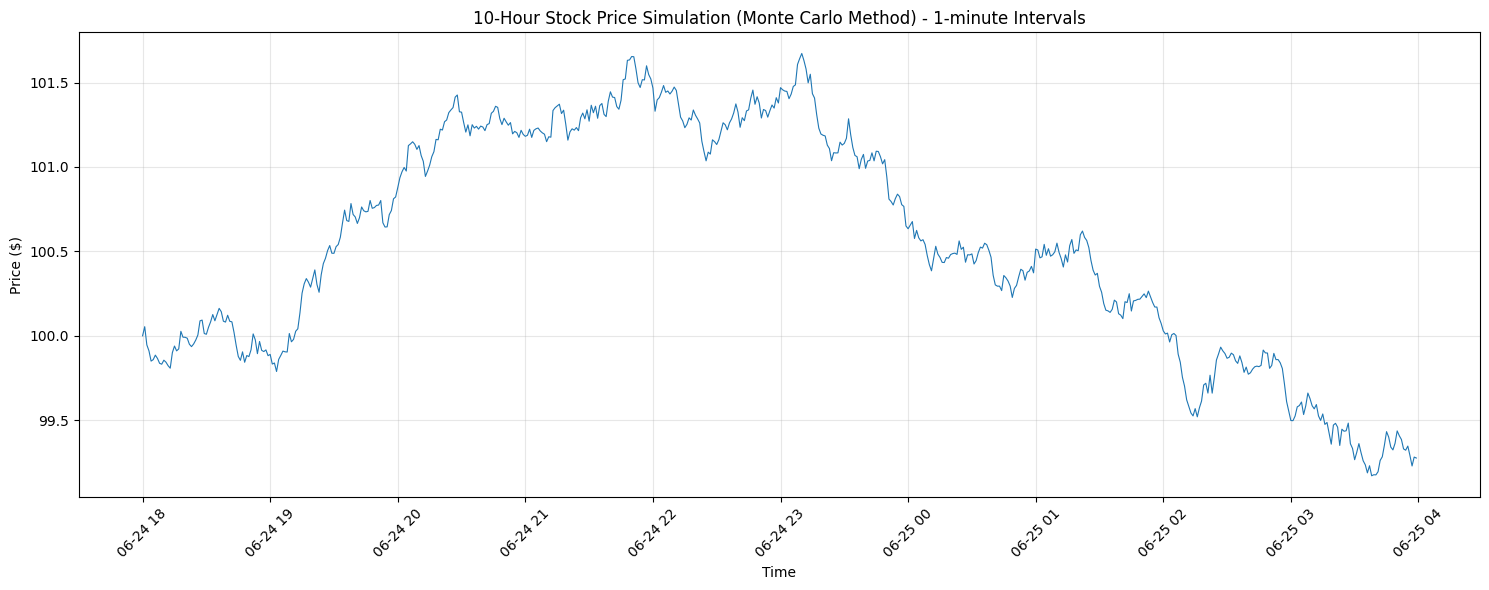

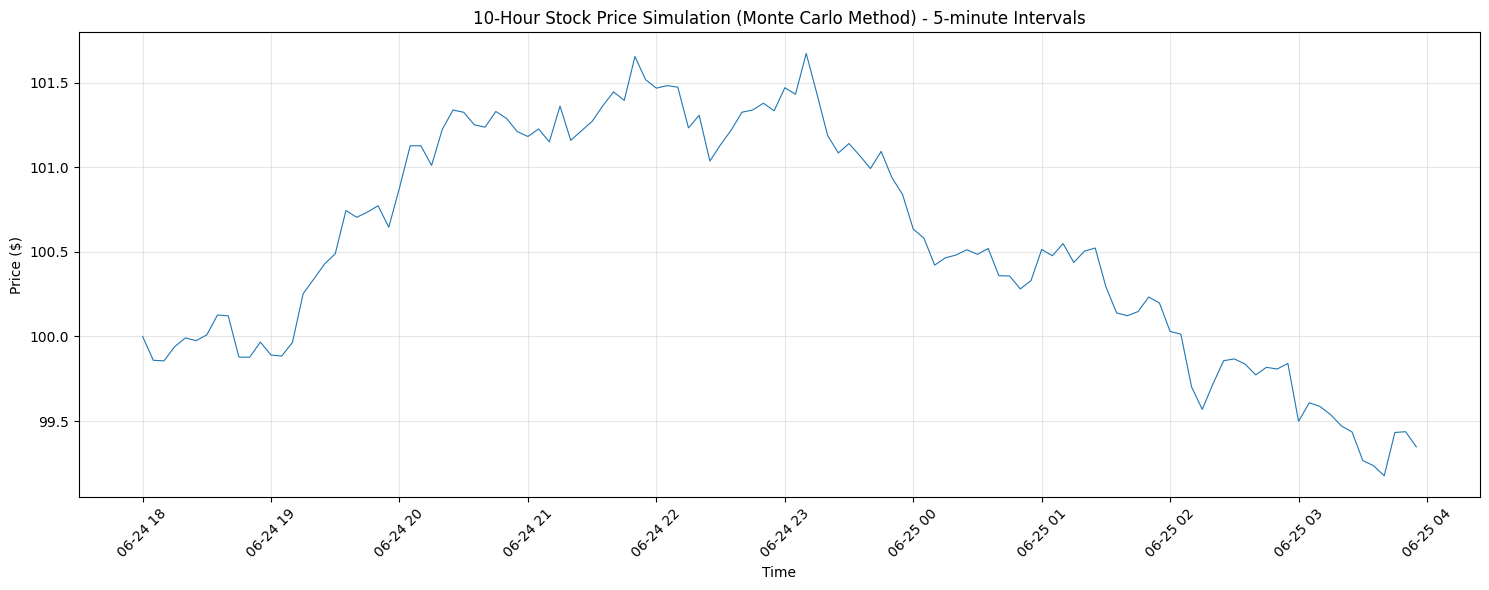

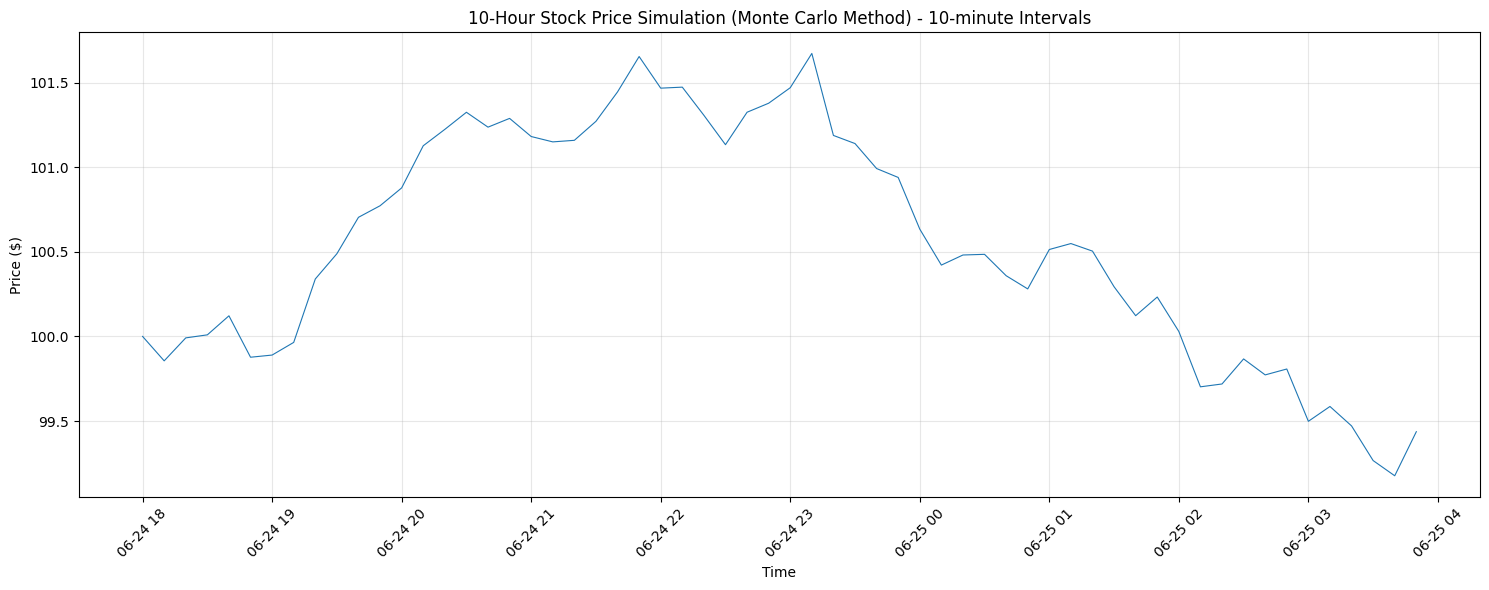

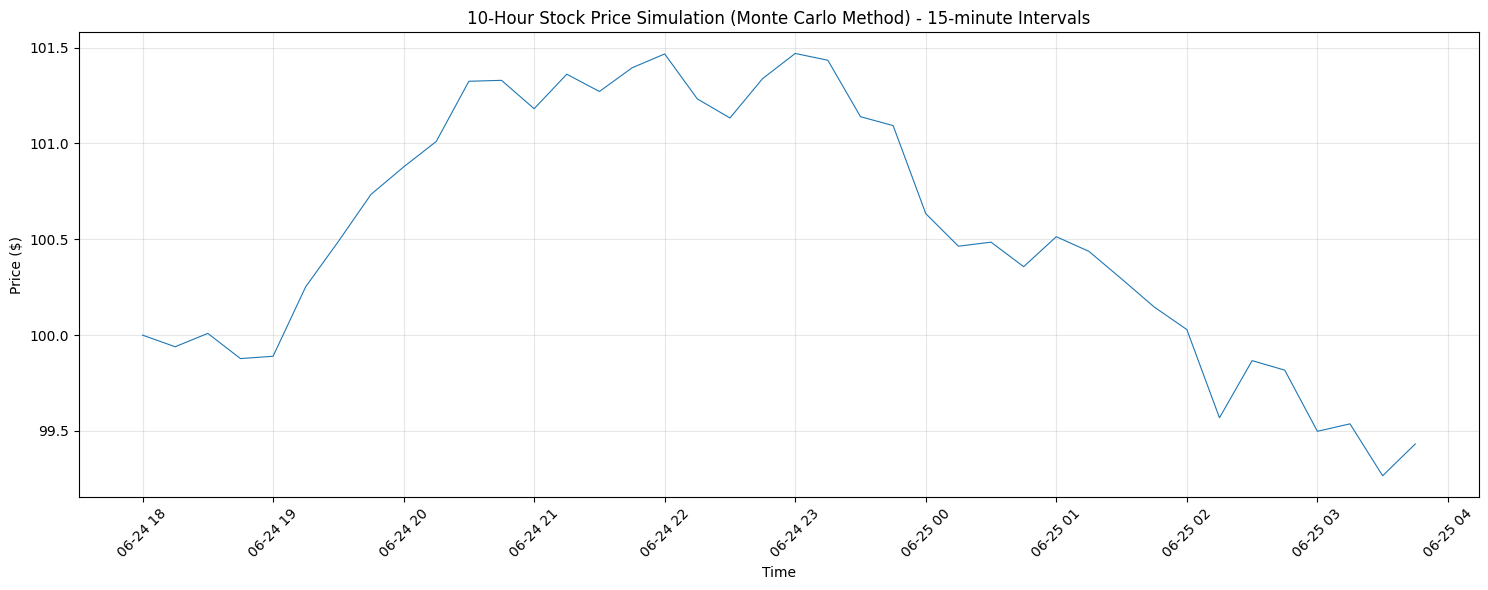

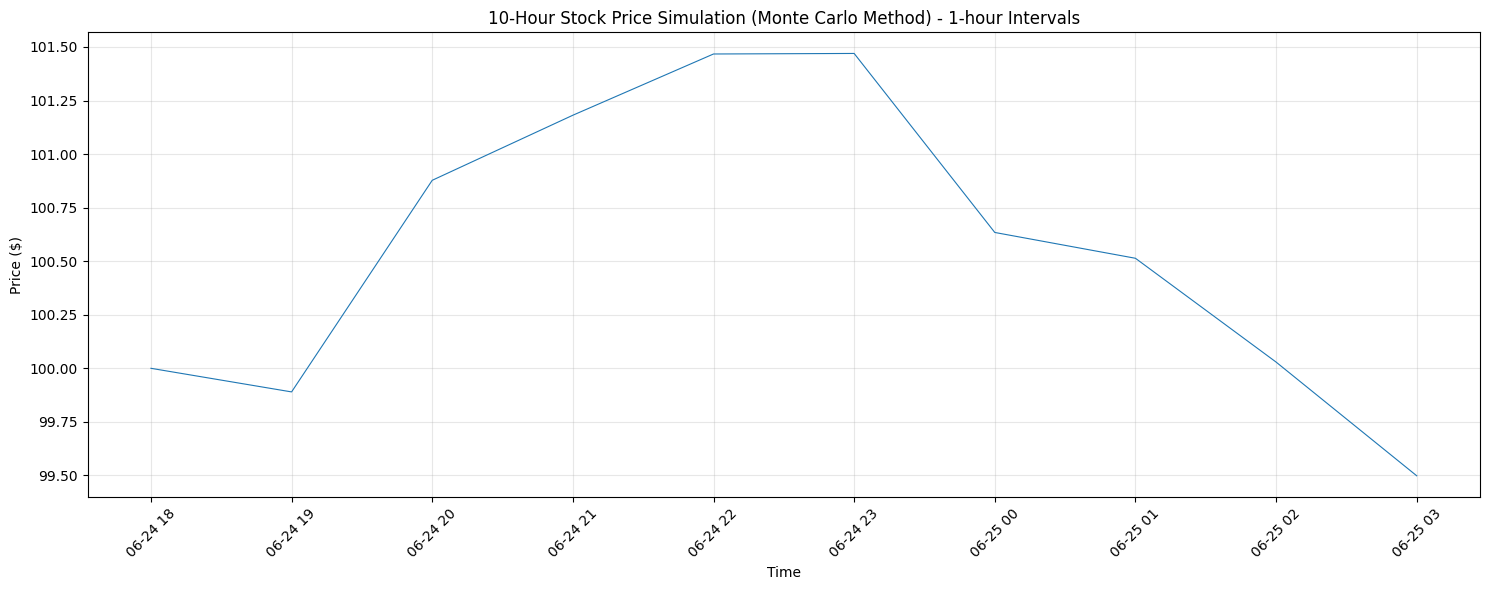

In [6]:
import numpy as np

# Generate the data with 5 seconds intervals for 23 hours
interval = 5  # 1 second intervals
hours = 23  
np.random.seed(42)  # For reproducible results

SOURCE = 1 # 1 = Monte Carlo, 2 = OANDA

# Generate stock price data using Monte Carlo method    
if SOURCE == 1:
    print("Generating stock price data using Monte Carlo method...")
    hours = int(input("Number of hours to fetch (e.g., 10): "))
    stock_df = generate_stock_price_data(interval=5, hours=hours) # 1-second intervals

if SOURCE == 2:
    # Generate stock data from OANDA API
    instrument = input("Instrument (e.g., USD_CAD): ")
    granularity = 'S5' # input("Granularity (e.g., S5, M1, M5): ")
    hours = int(input("Number of hours to fetch (e.g., 10): "))
    api_key = input("API Key please: ")
    stock_df = get_oanda_data(
        api_key=api_key,
        account_id='001-002-6172489-007',
        instrument=instrument,
        granularity=granularity,
        hours=hours
    )

# from stock_df, create different intervals
stock_5sec = stock_df.copy()
stock_1min = stock_df[::12].reset_index(drop=True)  # Every 12th row for 1-minute intervals
stock_5min =  stock_df[::60].reset_index(drop=True)  # Every 60th row for 5-minute intervals
stock_10min = stock_df[::120].reset_index(drop=True)  # Every 120th row for 10-minute intervals
stock_15min = stock_df[::180].reset_index(drop=True)  # Every 180th row for 15-minute intervals
stock_1hour = stock_df[::720].reset_index(drop=True)  # Every 720th row for 1-hour intervals
stock_variable = create_variable_interval_data(stock_df, min_interval=1, max_interval=2) # variable intervals


# Plot the stock price over the specified time period
for df, label in zip([stock_variable, stock_5sec, stock_1min, stock_5min, stock_10min, stock_15min, stock_1hour], 
                   ['Variable', '5-second', '1-minute', '5-minute', '10-minute', '15-minute', '1-hour']):
    plt.figure(figsize=(15, 6))
    plt.plot(df['timestamp'], df['price'], linewidth=0.8, label=f'{label} intervals')
    plt.title(f'{hours:.0f}-Hour Stock Price Simulation (Monte Carlo Method) - {label} Intervals')
    plt.xlabel('Time')
    plt.ylabel('Price ($)')
    plt.grid(True, alpha=0.3)
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

In [7]:
stock_variable

,timestamp,price
0,2025-06-24 18:00:00,100.000000
1,2025-06-24 18:00:10,100.005455
2,2025-06-24 18:00:15,100.015311
3,2025-06-24 18:00:25,100.034927
4,2025-06-24 18:00:30,100.031364
...,...,...
4752,2025-06-25 03:59:15,99.243700
4753,2025-06-25 03:59:25,99.242970
4754,2025-06-25 03:59:35,99.269227
4755,2025-06-25 03:59:45,99.280526


# Execution: Add Moving Averages to Data Frame

In [8]:
df = None
df = stock_5sec.copy()  # Use the 5-second interval data for EMA calculation
# df = stock_1min.copy()  # Use the 1-minute interval data for EMA calculation
# df = stock_5min.copy()  # Use the 5-minute interval data for EMA calculation
# df = stock_1hour.copy()  # Use the 1-hour interval
# df = stock_variable.copy()  # Use the variable interval

# Add EMA to the DataFrame
df['EMA_15min'] = calculate_time_based_ema(df, type=1, period_minutes=15)
# df['DEMA_15min'] = calculate_time_based_ema(df, type=2, period_minutes=15)
df['TEMA_15min'] = calculate_time_based_ema(df, type=3, period_minutes=15)

df

# stock_df

,timestamp,price,EMA_15min,TEMA_15min
0,2025-06-24 18:00:00,100.000000,100.000000,100.000000
1,2025-06-24 18:00:05,100.007558,100.000084,100.000248
2,2025-06-24 18:00:10,100.005455,100.000143,100.000421
3,2025-06-24 18:00:15,100.015311,100.000310,100.000914
4,2025-06-24 18:00:20,100.038490,100.000732,100.002156
...,...,...,...,...
7195,2025-06-25 03:59:35,99.269227,99.308589,99.278350
7196,2025-06-25 03:59:40,99.273726,99.308204,99.277781
7197,2025-06-25 03:59:45,99.280526,99.307898,99.277452
7198,2025-06-25 03:59:50,99.278951,99.307578,99.277082


# Execution: Plot the data

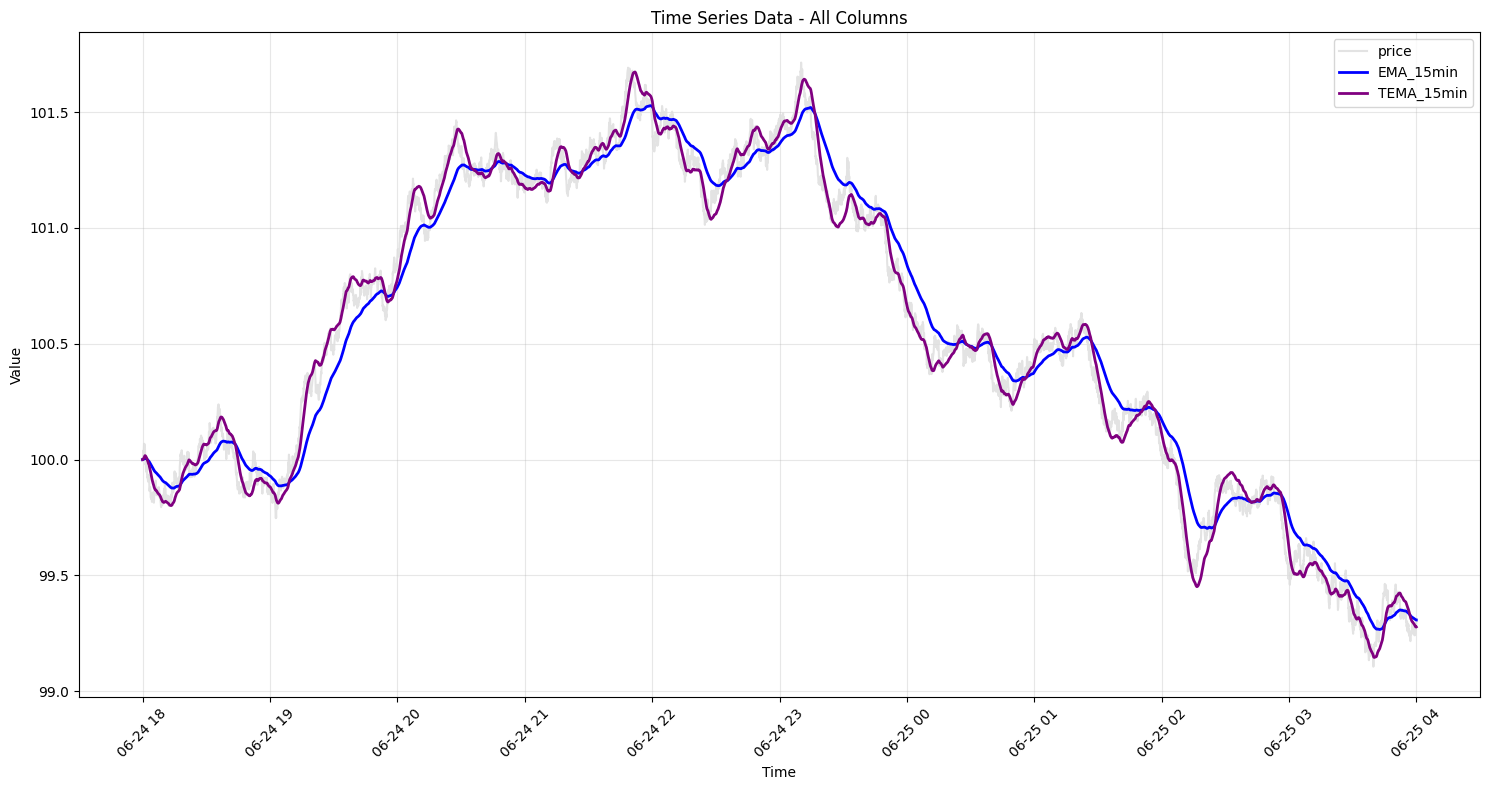

Plotted 3 columns: ['price', 'EMA_15min', 'TEMA_15min']


In [9]:
import matplotlib.pyplot as plt

def plot_time_series(df, exclude_columns=None):
    """
    Plot all columns except timestamp and excluded columns dynamically
    
    Parameters:
    -----------
    df : pandas.DataFrame
        DataFrame with timestamp column and data columns to plot
    exclude_columns : list or None
        List of column names to exclude from plotting (in addition to 'timestamp')
    """
    if exclude_columns is None:
        exclude_columns = []
    
    # Always exclude timestamp, plus any user-specified columns
    all_excluded = ['timestamp'] + exclude_columns
    
    plt.figure(figsize=(15, 8))
    
    # Find all columns except excluded ones
    plot_columns = [col for col in df.columns if col not in all_excluded]
    colors = ['#dddddd', 'blue', 'purple', 'green', 'purple', 'orange', 'brown', 'pink', 'olive', 'cyan', 'magenta']
    
    for i, col in enumerate(plot_columns):
        color = colors[i % len(colors)]  # Cycle through colors
        # Make first column (usually price) more prominent
        linewidth = 1.5 if i == 0 else 2
        alpha = 0.8 if i == 0 else 1.0
        plt.plot(df['timestamp'], df[col], 
                 color=color, linewidth=linewidth, alpha=alpha, label=col)
    
    plt.title('Time Series Data - All Columns')
    plt.xlabel('Time')
    plt.ylabel('Value')
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()
    
    if exclude_columns:
        print(f"Excluded columns: {exclude_columns}")
    print(f"Plotted {len(plot_columns)} columns: {plot_columns}")

# Plot with no exclusions
plot_time_series(df, exclude_columns=None)

# Example: Plot excluding specific EMAs
# plot_time_series(stock_df, exclude_columns=['EMA_30min', 'EMA_60min'])